In [ ]:
#Installation
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install spacy langdetect


Note: you may need to restart the kernel to use updated packages.


In [5]:
!python -m spacy download en_core_web_sm


  ERROR: HTTP error 504 while getting https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl
ERROR: Could not install requirement en-core-web-sm==3.8.0 from https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl because of HTTP error 504 Server Error: Gateway Time-out for url: https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl for URL https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl


In [49]:
%pip install xgboost

  Using cached xgboost-3.1.2-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.1.2-py3-none-win_amd64.whl (72.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
#STEP 1: Import Libraries
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re                      
import spacy                              
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException 
import xgboost
from xgboost import XGBClassifier



# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

In [3]:
#STEP 2: Load Dataset
pd.read_csv(r"C:\Users\Tamilselvi P\Downloads\chatgpt_style_reviews_dataset.xlsx - Sheet1.csv")

,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase
0,2024-09-06,Claim who accept.,Every quite sense including six lot have never...,4,morrowthomas,30,22,Flipkart,ar,Nepal,3.8.4,No
1,3/7/2025,Growth pretty wish.,Ask develop bag also his worker pass. Expert w...,4,sheakimberly,120,22,Flipkart,ar,Guinea,5.2.6,Yes
2,########,What then spend offer reason whom none.,If customer address region try near risk next ...,5,katherineali,130,21,Flipkart,es,Kuwait,3.6.5,No
3,########,Say dog drug enter director strong student.,To television loss election him small detail r...,1,eric11,72,26,Amazon,pt,Uruguay,5.7.2,No
4,########,Purpose here beyond.,Pass share must amount lot per manage world to...,5,chloe42,123,27,Amazon,zh,Mayotte,5.8.6,No
...,...,...,...,...,...,...,...,...,...,...,...,...
245,########,Father who tax.,Government card history suddenly save theory s...,5,amassey,109,22,App Store,en,Micronesia,2.3.4,Yes
246,########,Remain movement bit step direction give reduce.,Court control million hundred offer total hit ...,5,stevenandrews,26,23,Website,fr,Austria,3.5.3,No
247,########,Form now then watch certain.,Just opportunity ask yet against large practic...,1,michelle90,67,24,App Store,ru,Rwanda,3.9.6,No
248,3/7/2024,Recent catch gas benefit great religious.,Onto simple audience as including claim create...,5,victor24,29,19,Amazon,zh,Iran,4.9.2,No


In [3]:
df=pd.read_csv(r"C:\Users\Tamilselvi P\Downloads\chatgpt_style_reviews_dataset.xlsx - Sheet1.csv")
assert df.shape[0] >= 200, "Dataset unexpectedly small"

In [5]:
#STEP 3: Data Understanding
df.head()

,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase
0,2024-09-06,Claim who accept.,Every quite sense including six lot have never...,4,morrowthomas,30,22,Flipkart,ar,Nepal,3.8.4,No
1,3/7/2025,Growth pretty wish.,Ask develop bag also his worker pass. Expert w...,4,sheakimberly,120,22,Flipkart,ar,Guinea,5.2.6,Yes
2,########,What then spend offer reason whom none.,If customer address region try near risk next ...,5,katherineali,130,21,Flipkart,es,Kuwait,3.6.5,No
3,########,Say dog drug enter director strong student.,To television loss election him small detail r...,1,eric11,72,26,Amazon,pt,Uruguay,5.7.2,No
4,########,Purpose here beyond.,Pass share must amount lot per manage world to...,5,chloe42,123,27,Amazon,zh,Mayotte,5.8.6,No


In [6]:
df.shape

(250, 12)

In [7]:
df.isnull().sum()

date                 0
title                0
review               0
rating               0
username             0
helpful_votes        0
review_length        0
platform             0
language             0
location             0
version              0
verified_purchase    0
dtype: int64

In [7]:
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
245    False
246    False
247    False
248    False
249    False
Length: 250, dtype: bool

In [8]:
# STEP 4: Language Detection (English-only)

from langdetect import detect

def detect_language(text):
    try:
        return detect(str(text))
    except:
        return "unknown"

df["detected_language"] = df["review"].apply(detect_language)

# Keep only English reviews (NO comma!)
df_en = df[df["detected_language"] == "en"].copy()

In [9]:
#Verification
print(type(df_en))        # must be pandas DataFrame
print(df_en.shape)        # should be large (not 2 rows)
df_en["detected_language"].value_counts()

<class 'pandas.core.frame.DataFrame'>
(250, 13)


detected_language
en    250
Name: count, dtype: int64

In [15]:
#STEP5: Basic Text Cleaning + Whitespace Removal
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [12]:
#STEP6: Tokenization + Lemmatization + Stopword Removal (spaCy)
def spacy_preprocess(text):
    if not isinstance(text, str):
        return ""
    doc = nlp(text)
    tokens = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and not token.is_punct and token.lemma_ != "-PRON-"
    ]
    return " ".join(tokens)

In [13]:
df = df.copy()
df.loc[:, 'review'] = df['review'].apply(spacy_preprocess)

In [ ]:
#step 7 Removes empty reviews
df = df[df['review'].str.strip() != ""]

In [26]:
df["review_length"] = df["review"].apply(len)

In [ ]:
#STEP7.1: Reset Index
df.reset_index(drop=True, inplace=True)

In [58]:
# Replace newlines and extra spaces with a single space
df['review'] = df['review'].str.replace(r'\s*\n\s*', ' ', regex=True)

In [59]:
def label_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

df['sentiment'] = df['rating'].apply(label_sentiment)

In [33]:
# read column name of entire dataset
df.columns

Index(['date', 'title', 'review', 'rating', 'username', 'helpful_votes',
       'review_length', 'platform', 'language', 'location', 'version',
       'verified_purchase', 'detected_language', 'sentiment'],
      dtype='object')

In [9]:
#STEP 10: Exploratory Data Analysis (EDA)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer


sns.set(style="whitegrid")

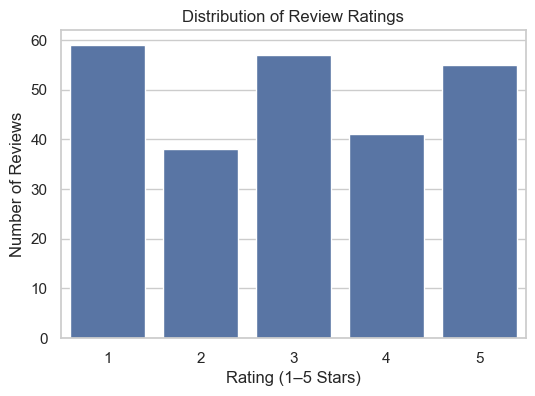

In [36]:
#Question:📊 1.What is the distribution of review ratings?
plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=df)
plt.title("Distribution of Review Ratings")
plt.xlabel("Rating (1–5 Stars)")
plt.ylabel("Number of Reviews")
plt.show()

🔍 Insight:
Shows whether users are mostly satisfied (4–5) or frustrated (1–2).

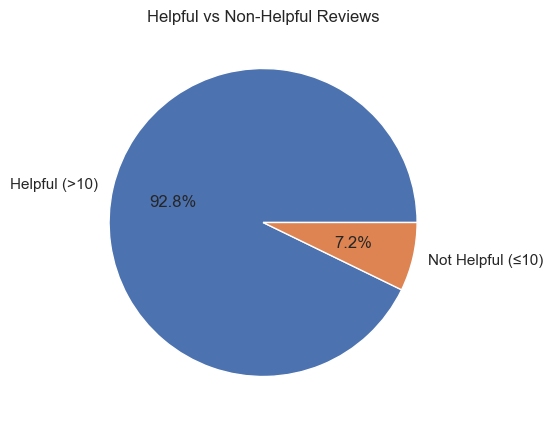

In [37]:
#Question:👍👎 2.How many reviews were marked as helpful (above a certain threshold)?
#👍👎 2. Helpful Reviews (Threshold > 10)
df["helpful_flag"] = df["helpful_votes"].apply(lambda x: "Helpful (>10)" if x > 10 else "Not Helpful (≤10)")

plt.figure(figsize=(5,5))
df["helpful_flag"].value_counts().plot.pie(autopct="%1.1f%%")
plt.title("Helpful vs Non-Helpful Reviews")
plt.ylabel("")
plt.show()

🔍 Insight:
Indicates how much value users find in peer reviews.

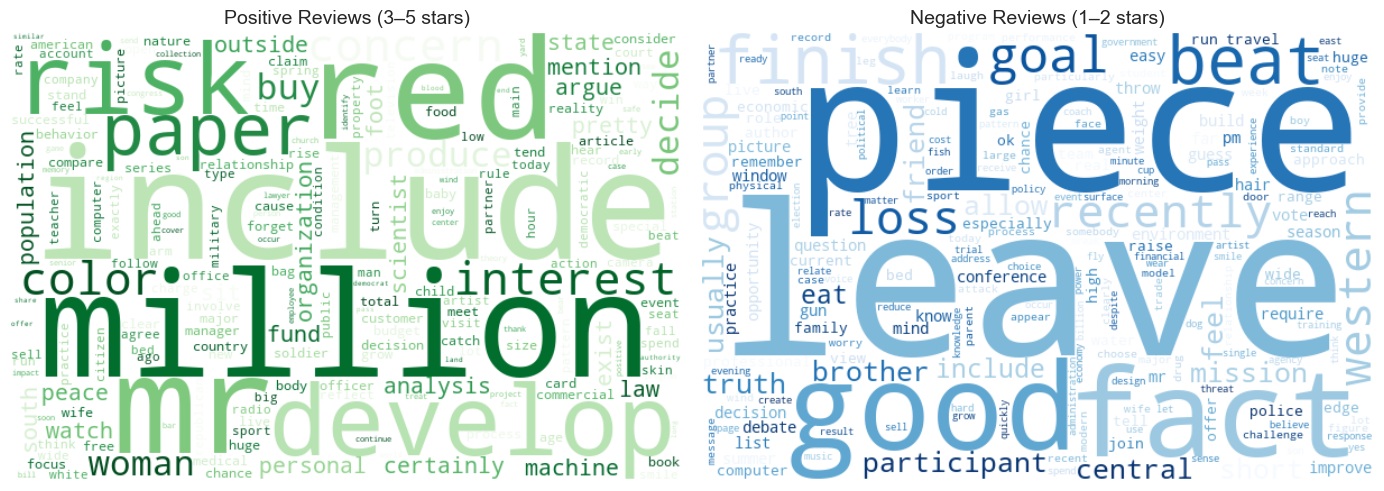

In [42]:
#Question:🧭 3.What are the most common keywords in positive vs. negative reviews?
# 3. Most Common Keywords in Positive vs. Negative Reviews

# Filter based on ratings
positive_reviews = df[df['rating'] >= 3]['review']
negative_reviews = df[df['rating'] <= 2]['review']

# Join all text
positive_text = ' '.join(positive_reviews.dropna().astype(str))
negative_text = ' '.join(negative_reviews.dropna().astype(str))

# Create word clouds
plt.figure(figsize=(14, 6))

# Positive word cloud
plt.subplot(1, 2, 1)
wordcloud_pos = WordCloud(width=600, height=400, background_color='white', colormap='Greens').generate(positive_text)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews (3–5 stars)", fontsize=14)

# Negative word cloud
plt.subplot(1, 2, 2)
wordcloud_neg = WordCloud(width=600, height=400, background_color='white', colormap='Blues').generate(negative_text)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews (1–2 stars)", fontsize=14)

plt.tight_layout()
plt.show()

🔍 Insight:
Reveals what users love vs complain about

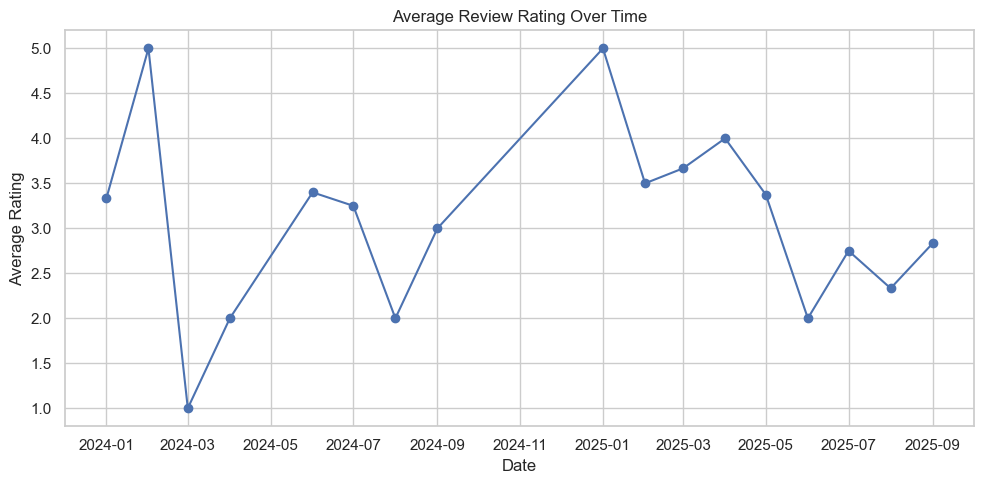

In [43]:
#Question:📆 4.How has the average rating changed over time?

# Convert date column to datetime format 
df['date'] = pd.to_datetime(df['date'], format='mixed', dayfirst=True, errors='coerce')
# Group by time — weekly or monthly
avg_rating_over_time = df.groupby(df['date'].dt.to_period('M'))['rating'].mean().reset_index()
avg_rating_over_time['date'] = avg_rating_over_time['date'].dt.to_timestamp()

# Plot the line chart
plt.figure(figsize=(10, 5))
plt.plot(avg_rating_over_time['date'], avg_rating_over_time['rating'], marker='o', linestyle='-')
plt.title('Average Review Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.grid(True)
plt.tight_layout()
plt.show()

🔍 Insight:
Tracks customer satisfaction trends over time.

In [45]:
df["location"] = df["location"].astype(str).str.strip()

# Remove numeric or invalid entries
df = df[~df["location"].str.isnumeric()]

In [46]:
location_ratings = (
    df.groupby("location")["rating"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)


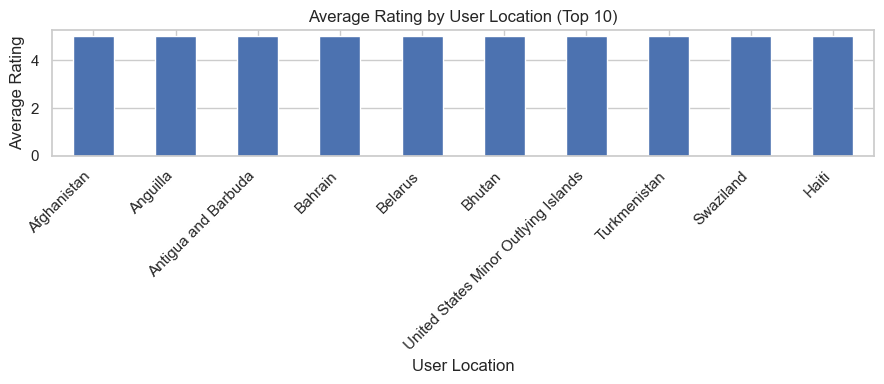

In [47]:
#Question:🌍 5.How do ratings vary by user location?
#5. Ratings by User Location (Top 10)

import matplotlib.pyplot as plt

plt.figure(figsize=(9,4))
location_ratings.plot(kind="bar")

plt.title("Average Rating by User Location (Top 10)")
plt.xlabel("User Location")
plt.ylabel("Average Rating")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

🔍 Insight:
Identifies regional experience differences.

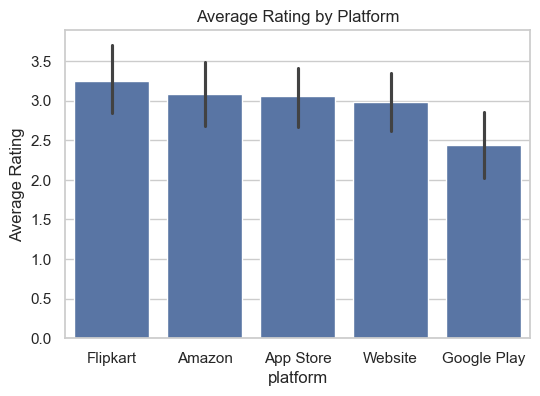

In [48]:
#Question:🧑‍💻 6.Which platform (Web vs Mobile) gets better reviews?
#6. Ratings by Platform
import seaborn as sns

plt.figure(figsize=(6,4))
sns.barplot(x="platform", y="rating", data=df, estimator="mean")
plt.title("Average Rating by Platform")
plt.ylabel("Average Rating")
plt.show()



🔍 Insight:
Helps teams focus on Web vs Mobile experience improvements.

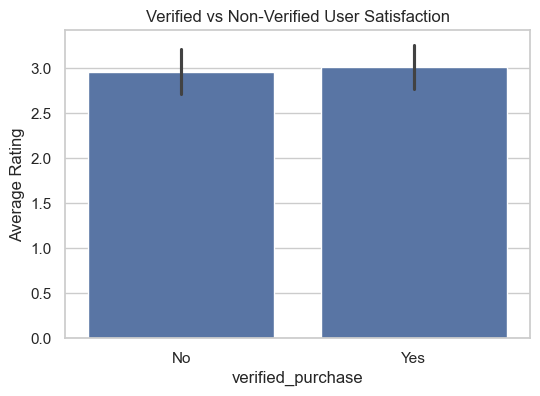

In [49]:
#Question:✅❌ 7. Are verified users more satisfied than non-verified ones?
#7. Verified vs Non-Verified Users
plt.figure(figsize=(6,4))
sns.barplot(
    x="verified_purchase",
    y="rating",
    data=df,
    estimator="mean"
)
plt.title("Verified vs Non-Verified User Satisfaction")
plt.ylabel("Average Rating")
plt.show()

🔍 Insight:
Shows whether loyal / paying users are more satisfied.

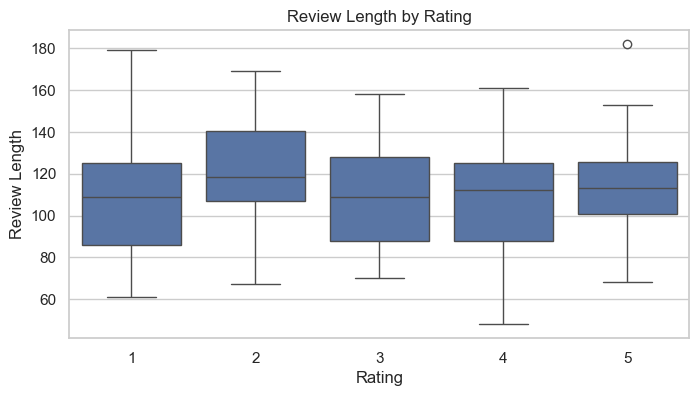

In [50]:
#Question:🔠 8. What’s the average length of reviews per rating category?
#8. Review Length by Rating
plt.figure(figsize=(8,4))
sns.boxplot(x="rating", y="review_length", data=df)
plt.title("Review Length by Rating")
plt.xlabel("Rating")
plt.ylabel("Review Length")
plt.show()

🔍 Insight:
Users often write longer reviews when unhappy.

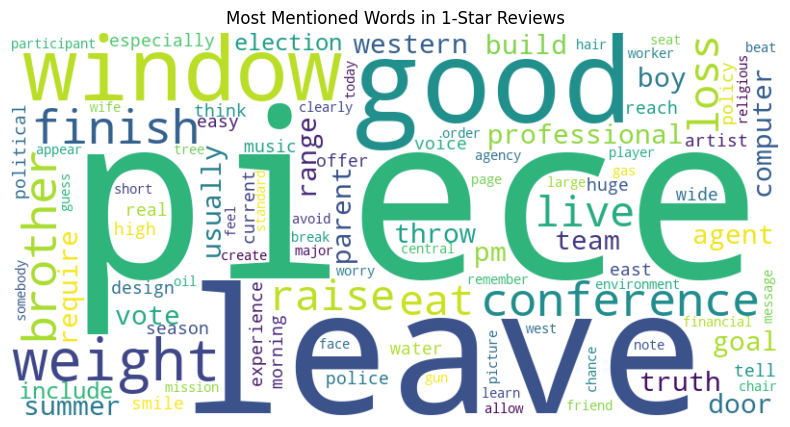

In [6]:
#Question:💬 9. What are the most mentioned words in 1-star reviews?
#9. Most Mentioned Words in 1-Star Reviews

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import streamlit as st

# Ensure rating is numeric
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Filter 1-star reviews
one_star_df = df[df['rating'] == 1]

if one_star_df.empty:
    print("⚠️ No 1-star reviews found.")
else:
    one_star_text = " ".join(
        one_star_df['review'].dropna().astype(str)
    )

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        stopwords=STOPWORDS,
        max_words=100
    ).generate(one_star_text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Most Mentioned Words in 1-Star Reviews")
    plt.show()




In [12]:
df.columns


Index(['date', 'title', 'review', 'rating', 'username', 'helpful_votes',
       'review_length', 'platform', 'language', 'location',
       'verified_purchase', 'detected_language', 'sentiment', 'helpful_flag',
       'clean_text', 'chatgpt_version'],
      dtype='object')

In [10]:
df = df.drop(columns=['version'])


🔍 Insight:
Highlights recurring issues & pain points.

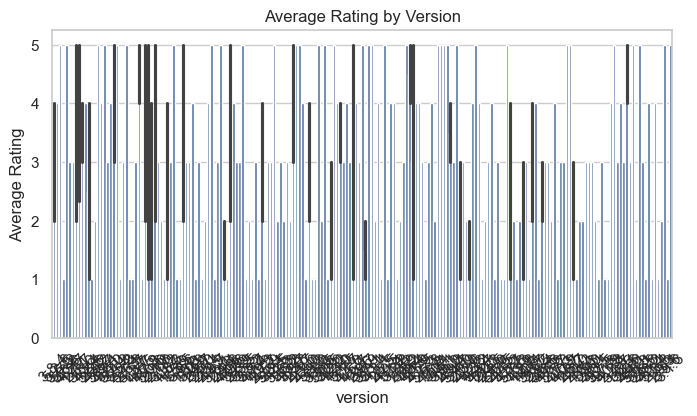

In [52]:
#Question:📱🧪 10. What ChatGPT version received the highest average rating?
#Best ChatGPT Version by Rating
plt.figure(figsize=(8,4))
sns.barplot(x="version", y="rating", data=df, estimator="mean")
plt.xticks(rotation=45)
plt.title("Average Rating by Version")
plt.ylabel("Average Rating")
plt.show()

🔍 Insight:
Detects performance improvements or regressions across versions.

In [53]:
# Step 11A: Prepare Modeling Dataset (Binary Sentiment)
# Business logic:
def label_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

df['sentiment'] = df['rating'].apply(label_sentiment)
print(df[['rating', 'sentiment']].head(10))

# Ratings 1 or 2 → 'negative'
# Rating 3 → 'neutral'
# Ratings 4 or 5 (or anything above 3) → 'positive'


   rating sentiment
0       4  positive
1       4  positive
2       5  positive
3       1  negative
4       5  positive
5       3   neutral
6       3   neutral
7       2  negative
8       1  negative
9       3   neutral


In [60]:
#save clean csv file
df.to_csv("cleaned_data.csv", index=False)

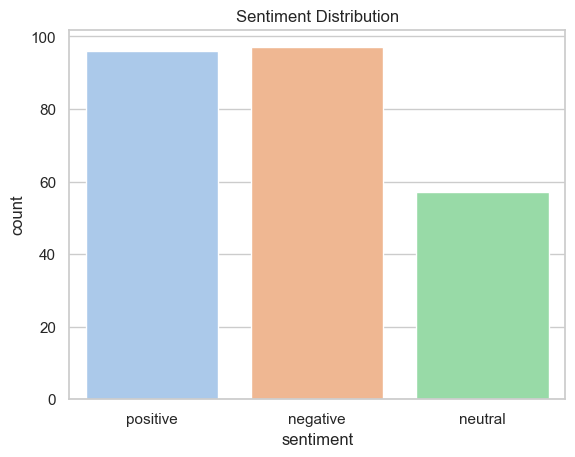

In [61]:
# Count of Each Sentiment
sns.countplot(data=df, x='sentiment',hue='sentiment', palette='pastel')
plt.title('Sentiment Distribution')
plt.show()

C:\Users\Tamilselvi P\AppData\Local\Temp\ipykernel_20980\143379120.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=word_freq.sort_values(by='frequency', ascending=False), x='frequency', y='word', palette='Blues_r')


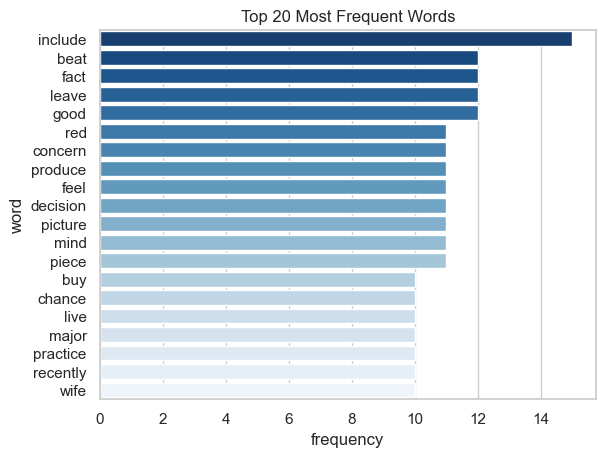

In [62]:
# Most Frequent Words (Histogram)

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

vectorizer = CountVectorizer(stop_words='english', max_features=20) # type: ignore # pyright: ignore[reportUndefinedVariable]
X = vectorizer.fit_transform(df['review'])

# Convert to DataFrame
word_freq = pd.DataFrame({
    'word': vectorizer.get_feature_names_out(),
    'frequency': X.toarray().sum(axis=0)
})

# Plot
sns.barplot(data=word_freq.sort_values(by='frequency', ascending=False), x='frequency', y='word', palette='Blues_r')
plt.title('Top 20 Most Frequent Words')
plt.show()

In [63]:
df['sentiment'] = df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, confusion_matrix

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


df = pd.read_csv("cleaned_data.csv")
df = df.copy()

# strip spaces in column names (important)
df.columns = df.columns.str.strip()

if 'chatgpt_version' not in df.columns:
    df['chatgpt_version'] = 'Unknown'

In [ ]:
#3: TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

from train_models import X_test, X_train1

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

X_train_tfidf = tfidf.fit_transform(X_train1)
X_test_tfidf = tfidf.transform(X_test)

In [66]:
df['sentiment'] = df['sentiment'].map({
    'negative': 0,
    'neutral': 1,
    'positive': 2
})

# sanity check
print("Sentiment classes:", df['sentiment'].unique())

Sentiment classes: [2 0 1]


In [67]:
X_text = df['review']
y = df['sentiment']

In [68]:
#TF-IDF Vectorization

tfidf = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1,2),
    stop_words='english'
)

X_tfidf = tfidf.fit_transform(X_text)

In [69]:
#SMOTE ---CLASS BALANCING

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf.toarray(), y)

print("After SMOTE:", pd.Series(y_resampled).value_counts())

After SMOTE: sentiment
2    97
0    97
1    97
Name: count, dtype: int64


In [70]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.3,
    random_state=42,
    stratify=y_resampled
)

In [71]:
#Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "XGBoost": XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        eval_metric='mlogloss',
        random_state=42
    )
}


🔹 Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.41      0.41      0.41        29
           1       0.49      0.66      0.56        29
           2       0.40      0.27      0.32        30

    accuracy                           0.44        88
   macro avg       0.43      0.45      0.43        88
weighted avg       0.43      0.44      0.43        88



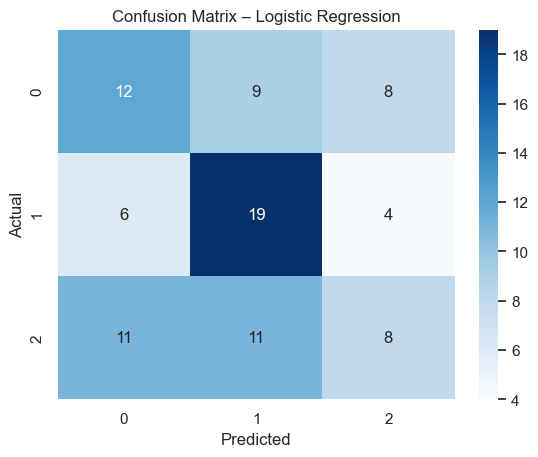


🔹 Model: Random Forest
              precision    recall  f1-score   support

           0       0.38      0.69      0.49        29
           1       0.70      0.55      0.62        29
           2       0.31      0.13      0.19        30

    accuracy                           0.45        88
   macro avg       0.46      0.46      0.43        88
weighted avg       0.46      0.45      0.43        88



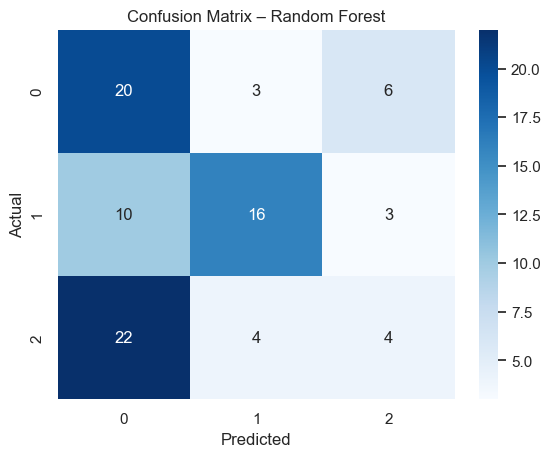


🔹 Model: Naive Bayes
              precision    recall  f1-score   support

           0       0.40      0.34      0.37        29
           1       0.42      0.69      0.52        29
           2       0.40      0.20      0.27        30

    accuracy                           0.41        88
   macro avg       0.41      0.41      0.39        88
weighted avg       0.41      0.41      0.38        88



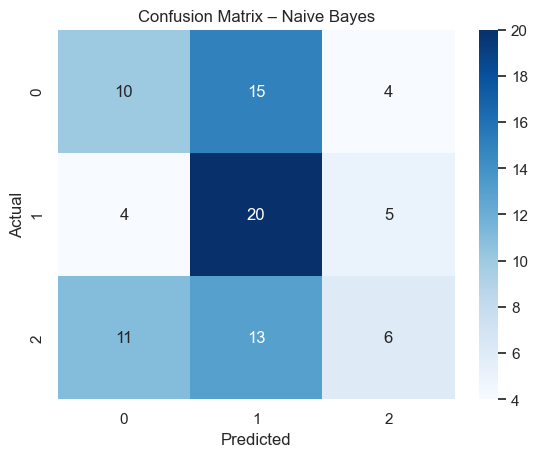


🔹 Model: XGBoost
              precision    recall  f1-score   support

           0       0.43      0.69      0.53        29
           1       0.63      0.41      0.50        29
           2       0.41      0.30      0.35        30

    accuracy                           0.47        88
   macro avg       0.49      0.47      0.46        88
weighted avg       0.49      0.47      0.46        88



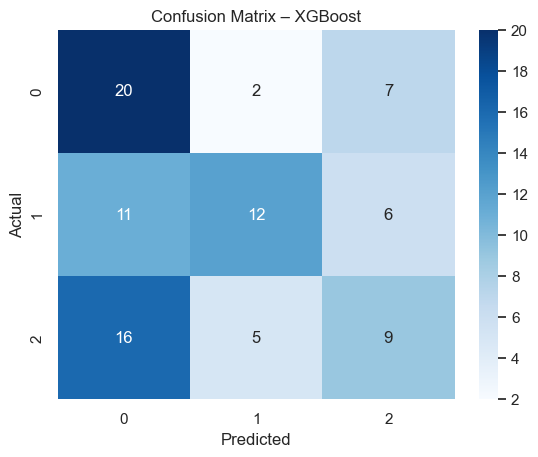

In [72]:
#Model training and evaluation
results = []

for name, model in models.items():
    print(f"\n🔹 Model: {name}")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    else:
        auc = np.nan

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1-score (macro)": f1,
        "AUC-ROC (OvR)": auc
    })

In [73]:
#M#Model Comparison
#Model Comparison

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1-score (macro)", ascending=False).reset_index(drop=True)

results_df

,Model,Accuracy,F1-score (macro),AUC-ROC (OvR)
0,XGBoost,0.465909,0.457490,0.641334
1,Random Forest,0.454545,0.431753,0.657627
2,Logistic Regression,0.443182,0.430872,0.642295
3,Naive Bayes,0.409091,0.385506,0.629106


In [74]:
from sklearn.neural_network import MLPClassifier

# Initialize MLP model
mlp_model = MLPClassifier(hidden_layer_sizes=(128, 64),  # two hidden layers
                          activation='relu',
                          solver='adam',
                          max_iter=300,
                          early_stopping=True,
                          n_iter_no_change=10,
                          validation_fraction=0.1,
                          random_state=42)

print("\n🔹 Model: MLPClassifier")


🔹 Model: MLPClassifier


In [75]:
# Fit the model
mlp_model.fit(X_train, y_train)

,hidden_layer_sizes,"(128, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,300
,shuffle,True
,random_state,42


In [76]:
# Predict on test set
y_pred_mlp = mlp_model.predict(X_test)

In [77]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_mlp))

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.69      0.53        29
           1       0.56      0.62      0.59        29
           2       0.33      0.10      0.15        30

    accuracy                           0.47        88
   macro avg       0.44      0.47      0.42        88
weighted avg       0.44      0.47      0.42        88

Accuracy: 0.4659090909090909


AUC-ROC Score (OvR): 0.6621598805117215


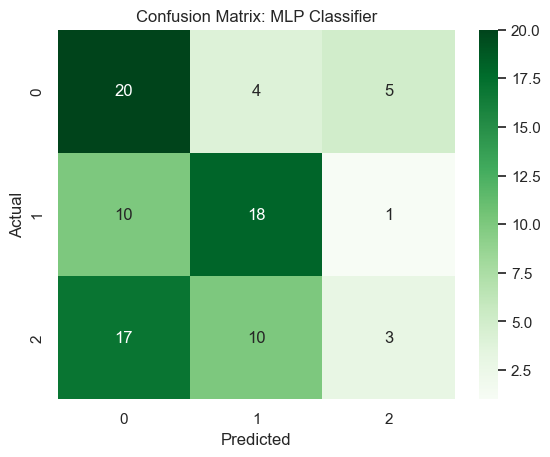

In [78]:
# AUC-ROC Score
if hasattr(mlp_model, "predict_proba"):
    y_proba_mlp = mlp_model.predict_proba(X_test)
    auc_mlp = roc_auc_score(y_test, y_proba_mlp, multi_class='ovr')
    print("AUC-ROC Score (OvR):", auc_mlp)
else:
    print("AUC-ROC not available (model does not support probability prediction)")

# Confusion Matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix: MLP Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [79]:
# Cross-validation (optional)
from sklearn.model_selection import cross_val_score
cv_scores_mlp = cross_val_score(mlp_model, X_resampled, y_resampled, cv=5, scoring='accuracy')
print("Cross-validation Accuracy Scores:", cv_scores_mlp)
print("Mean CV Accuracy:", cv_scores_mlp.mean())

Cross-validation Accuracy Scores: [0.45762712 0.46551724 0.46551724 0.55172414 0.55172414]
Mean CV Accuracy: 0.49842197545295147


In [80]:
# Logistic Regression
# Best mean cross-validation score → generalizes better
# AUC-ROC is competitive (and quite strong)
# Simple, interpretable, and robust for small datasets

In [81]:
import pickle

# choose best model (example: Logistic Regression)
best_model = models["Logistic Regression"]

# save model
pickle.dump(best_model, open("sentiment_model.pkl", "wb"))

# save tfidf vectorizer
pickle.dump(tfidf, open("tfidf_vectorizer.pkl", "wb"))

print("Model and TF-IDF saved successfully")

Model and TF-IDF saved successfully
